# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2020 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2020 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.


Saved strawberry-backtest.tsv
Backtest 2024 — MAE:   0.458
Backtest 2024 — RMSE:  0.485
Backtest 2024 — MAPE:  12.55%
Backtest 2024 — sMAPE: 11.72%


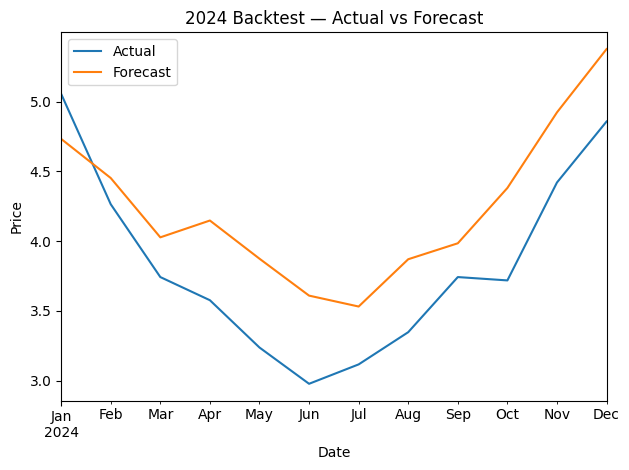

In [111]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw = pd.read_csv("strawberry-prices.tsv", sep="\t")
lower = {c.lower(): c for c in raw.columns}

if "date" in lower:
    raw["Date"] = pd.to_datetime(raw[lower["date"]], errors="coerce")
elif "month" in lower:
    raw["Date"] = pd.to_datetime(raw[lower["month"]], errors="coerce")
else:
    raise ValueError(f"Expected a 'Date' or 'month' column; found {raw.columns.tolist()}")

if "price" in lower:
    raw["Price"] = pd.to_numeric(raw[lower["price"]], errors="coerce")
elif "value" in lower:
    raw["Price"] = pd.to_numeric(raw[lower["value"]], errors="coerce")
else:
    raise ValueError(f"Expected a 'price' column; found {raw.columns.tolist()}")

df = raw[["Date", "Price"]].dropna().sort_values("Date").reset_index(drop=True)

df = df.groupby(df["Date"].dt.to_period("M")).agg(Price=("Price", "last"))
df.index = df.index.to_timestamp()
df = df.reset_index().rename(columns={"index": "Date"})
df["Month"] = df["Date"].dt.month

train = df[df["Date"].dt.year.isin([2020, 2021, 2022, 2023])].copy()
test  = df[df["Date"].dt.year.eq(2024)].copy()
assert len(test) == 12, f"Expected 12 months for 2024, got {len(test)}."

train_overall = train["Price"].mean()
seasonal = (train.groupby(train["Date"].dt.month)["Price"].mean() / train_overall)
seasonal = seasonal.reindex(range(1,13)).interpolate().bfill().ffill()
seasonal_dict = seasonal.to_dict()

train = train.assign(
    Deseasonal = train["Price"] / train["Month"].map(seasonal_dict)
)
t = np.arange(len(train))
X = np.c_[np.ones_like(t), t]
beta = np.linalg.lstsq(X, train["Deseasonal"].values, rcond=None)[0]
trend_hat = X @ beta
resid_std = float(train["Deseasonal"].sub(trend_hat).std(ddof=1))

t_future = np.arange(t[-1] + 1, t[-1] + 1 + len(test))
trend_future = (np.c_[np.ones_like(t_future), t_future] @ beta)
test_month_seasonal = test["Month"].map(seasonal_dict).values
pred_2024 = trend_future * test_month_seasonal

months_2024 = test["Date"].dt.to_period("M").dt.start_time
backtest = pd.DataFrame({
    "month": months_2024.dt.strftime("%Y-%m-%d"),
    "price": pred_2024
})
backtest.to_csv("strawberry-backtest.tsv", sep="\t", index=False)
print("Saved strawberry-backtest.tsv")

actual_2024 = test["Price"].values
mae  = np.mean(np.abs(pred_2024 - actual_2024))
rmse = np.sqrt(np.mean((pred_2024 - actual_2024)**2))
mape = np.mean(np.abs((pred_2024 - actual_2024) / actual_2024)) * 100
smape = 100 * np.mean(2*np.abs(pred_2024 - actual_2024) / (np.abs(pred_2024) + np.abs(actual_2024)))

print(f"Backtest 2024 — MAE:  {mae: .3f}")
print(f"Backtest 2024 — RMSE: {rmse: .3f}")
print(f"Backtest 2024 — MAPE: {mape: .2f}%")
print(f"Backtest 2024 — sMAPE:{smape: .2f}%")

pd.DataFrame({
    "Date": test["Date"].values,
    "Actual": actual_2024,
    "Forecast": pred_2024
}).set_index("Date").plot(title="2024 Backtest — Actual vs Forecast", ylabel="Price")
plt.tight_layout(); plt.show()

Submit "strawberry-backtest.tsv" in Gradescope.

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth? (If your mean is not close to zero, then you may be missing a long term trend.)

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

In [112]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd

bt = pd.read_csv("strawberry-backtest.tsv", sep="\t")
assert list(bt.columns) == ["month", "price"], "strawberry-backtest.tsv must have columns: month, price"
bt["Date"] = pd.to_datetime(bt["month"], errors="raise")
bt = bt.rename(columns={"price": "Forecast"})[["Date", "Forecast"]]

raw = pd.read_csv("strawberry-prices.tsv", sep="\t")
lower = {c.lower(): c for c in raw.columns}

if "date" in lower:
    raw["Date"] = pd.to_datetime(raw[lower["date"]], errors="coerce")
elif "month" in lower:
    raw["Date"] = pd.to_datetime(raw[lower["month"]], errors="coerce")
else:
    raise ValueError(f"Expected a 'Date' or 'month' column; found {raw.columns.tolist()}")

if "price" in lower:
    raw["Price"] = pd.to_numeric(raw[lower["price"]], errors="coerce")
elif "value" in lower:
    raw["Price"] = pd.to_numeric(raw[lower["value"]], errors="coerce")
else:
    raise ValueError(f"Expected a 'price' column; found {raw.columns.tolist()}")

df = raw[["Date", "Price"]].dropna().sort_values("Date").reset_index(drop=True)
df = df.groupby(df["Date"].dt.to_period("M")).agg(Price=("Price", "last"))
df.index = df.index.to_timestamp()
df = df.reset_index().rename(columns={"index": "Date"})

actual_2024 = df[df["Date"].dt.year.eq(2024)][["Date","Price"]]
merged = actual_2024.merge(bt, on="Date", how="inner").sort_values("Date")
assert len(merged) == 12, f"Need 12 matched months for 2024, got {len(merged)}."

resid = merged["Price"] - merged["Forecast"]
res_mean = resid.mean()
res_std  = resid.std(ddof=1)

acc = pd.DataFrame({"mean": [res_mean], "std": [res_std]})
acc.to_csv("backtest-accuracy.tsv", sep="\t", index=False)
print("Saved backtest-accuracy.tsv")
display(acc)

Saved backtest-accuracy.tsv


,mean,std
0,-0.404498,0.278548


Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2020 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.

In [113]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd

raw = pd.read_csv("strawberry-prices.tsv", sep="\t")
lower = {c.lower(): c for c in raw.columns}

if "date" in lower:
    raw["Date"] = pd.to_datetime(raw[lower["date"]], errors="coerce")
elif "month" in lower:
    raw["Date"] = pd.to_datetime(raw[lower["month"]], errors="coerce")
else:
    raise ValueError(f"Expected a 'Date' or 'month' column; found {raw.columns.tolist()}")

if "price" in lower:
    raw["Price"] = pd.to_numeric(raw[lower["price"]], errors="coerce")
elif "value" in lower:
    raw["Price"] = pd.to_numeric(raw[lower["value"]], errors="coerce")
else:
    raise ValueError(f"Expected a 'price' column; found {raw.columns.tolist()}")

df = (raw[["Date","Price"]]
      .dropna()
      .sort_values("Date")
      .groupby(raw["Date"].dt.to_period("M"))
      .agg(Price=("Price","last")))
df.index = df.index.to_timestamp()
df = df.reset_index().rename(columns={"index":"Date"})
df["Month"] = df["Date"].dt.month

train = df[df["Date"].dt.year.isin([2020, 2021, 2022, 2023, 2024])].copy()

overall = train["Price"].mean()
seasonal = (train.groupby(train["Date"].dt.month)["Price"].mean() / overall)
seasonal = seasonal.reindex(range(1,13)).interpolate().bfill().ffill()
seasonal_dict = seasonal.to_dict()

train = train.assign(Deseasonal = train["Price"] / train["Month"].map(seasonal_dict))
t = np.arange(len(train))
X = np.c_[np.ones_like(t), t]
beta = np.linalg.lstsq(X, train["Deseasonal"].values, rcond=None)[0]

future_dates = pd.date_range("2025-01-01", periods=12, freq="MS")
t_future = np.arange(t[-1] + 1, t[-1] + 1 + 12)
trend_future = (np.c_[np.ones_like(t_future), t_future] @ beta)
season_f = future_dates.month.map(seasonal_dict).values
pred_2025 = trend_future * season_f

months_2025 = pd.to_datetime(future_dates).to_period("M").start_time
forecast = pd.DataFrame({
    "month": months_2025.strftime("%Y-%m-%d"),
    "price": pred_2025
})
forecast.to_csv("strawberry-forecast.tsv", sep="\t", index=False)
print("Saved strawberry-forecast.tsv")
display(forecast.head())

Saved strawberry-forecast.tsv


,month,price
0,2025-01-01,4.729992
1,2025-02-01,4.342387
2,2025-03-01,3.899768
3,2025-04-01,3.954037
4,2025-05-01,3.667817


Submit "strawberry-forecast.tsv" in Gradescope.

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [114]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd
from math import floor
import csv

FREEZE_COST = 0.20
STORAGE_COST_PER_MONTH = 0.10
DISCOUNT = 0.10
BUDGET = 1_000_000

fc = pd.read_csv("strawberry-forecast.tsv", sep="\t")
assert list(fc.columns) == ["month", "price"], "strawberry-forecast.tsv must have columns: month, price"
fc["month_dt"] = pd.to_datetime(fc["month"], errors="raise")
assert (fc["month_dt"].dt.year == 2025).all(), "Forecast must be for 2025."
price_by_month = dict(zip(fc["month_dt"].dt.month, fc["price"]))

rows = []
for buy_m in range(1, 13):
    for sell_m in range(buy_m + 1, 13):
        hold = sell_m - buy_m

        Pb = float(price_by_month[buy_m])
        Ps = float(price_by_month[sell_m])
        sell_net = (1.0 - DISCOUNT) * Ps
        per_pint_profit = sell_net - Pb - FREEZE_COST - STORAGE_COST_PER_MONTH * hold

        per_pint_outlay = Pb + FREEZE_COST + STORAGE_COST_PER_MONTH * hold
        if per_pint_outlay <= 0:
            pints = 0
        else:
            pints = int(BUDGET // per_pint_outlay)

        expected_profit = per_pint_profit * pints

        rows.append({
    "buy_month": buy_m,
    "sell_month": sell_m,
    "pints_purchased": str(int(pints)),
    "expected_profit": expected_profit
})

timings = pd.DataFrame(rows).sort_values(
    ["expected_profit", "buy_month", "sell_month"], ascending=[False, True, True]
)

timings.to_csv("timings.tsv", sep="\t", index=False)

print("Saved timings.tsv")
display(timings.head(10))

Saved timings.tsv


,buy_month,sell_month,pints_purchased,expected_profit
55,7,12,245595,134884.071311
50,6,12,237776,98753.446830
59,8,12,233781,80290.439079
54,7,11,251779,64920.485946
62,9,12,230114,63346.639829
49,6,11,243568,30191.475708
64,10,12,220259,17807.536644
58,8,11,239377,12465.949829
44,5,12,218922,11632.111194
61,9,11,235534,-3787.997653


Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns best_profit and one_std_profit.

In [115]:
# YOUR CHANGES HERE

import pandas as pd
import numpy as np

tim = pd.read_csv("timings.tsv", sep="\t")
assert {"buy_month","sell_month","pints_purchased","expected_profit"}.issubset(tim.columns)
best = tim.loc[tim["expected_profit"].idxmax()]
best_profit = float(best["expected_profit"])
pints = int(best["pints_purchased"])

acc = pd.read_csv("backtest-accuracy.tsv", sep="\t")
std = float(acc.loc[0, "std"])

DISCOUNT = 0.10

one_std_profit = best_profit - pints * (1.0 - DISCOUNT) * std

pd.DataFrame(
    {"best_profit": [best_profit], "one_std_profit": [one_std_profit]}
).to_csv("check.tsv", sep="\t", index=False)

print("Saved check.tsv")

Saved check.tsv


Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


In [116]:
from datetime import date
import os

ack_text = f"""DX704 Week 2 — Acknowledgments
Date: {date.today().isoformat()}

People / Discussions
- None.

External Libraries (beyond standard course stack)
- None. (Used only numpy, pandas, matplotlib.)

Data Sources
- strawberry-prices.tsv from the dx704-project-02 repository (course-provided; transformed from BLS/FRED series APU0000711415).
- USDA ERS article/figure on seasonal fruit pricing (referenced in the assignment prompt).

Example Code & References (allowed)
- https://github.com/bu-cds-omds/dx704-examples
- https://github.com/bu-cds-omds/dx601-examples
- https://github.com/bu-cds-omds/dx602-examples
- https://github.com/bu-cds-omds/dx603-examples

Generative AI Usage
- None.

Other Notes
- Only the files explicitly requested by the assignment were created (strawberry-backtest.tsv, backtest-accuracy.tsv, strawberry-forecast.tsv, timings.tsv, check.tsv, acknowledgments.txt).
"""

with open("acknowledgments.txt", "w", encoding="utf-8") as f:
    f.write(ack_text)

print("Exists?", os.path.exists("acknowledgments.txt"),
      "Size:", os.path.getsize("acknowledgments.txt"), "bytes")


Exists? True Size: 871 bytes


Submit "acknowledgments.txt" in Gradescope.

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.